В приложенном файле 3 датасета:

1. Данные треков - Richtracks (описание приложено)
2. Данные точек этих треков - IncomingTrackPoints (описание также приложено)
3. Наборы токен-платформа (iOS или Android)

Задание:

1. Некоторые параметры набора точек для трека имеют различную размерность в зависимости от платформы (iOS или Android) - какие это параметры?
2. Переведите все параметры в одинаковую размерность
3. В richtracks для каждого трека есть поле TrackOrigin, которое описывает кем была произведена поездка: владельцем смартфона или нет. 

Задание: постройте модель, предсказывающую на основании данных из входящих точек, была ли поездка пассажирской или нет.

## 1. Некоторые параметры набора точек для трека имеют различную размерность в зависимости от платформы (iOS или Android) - какие это параметры?

1. Подключим библиотеки.
2. Загрузим все файлы и соединим их, добавив бинарную переменную, показывающую была ли совершена поездка пассажиром.
3. Посмотрим на данные и поймём, где проблемы с размерностью

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling #pandas profiling library
import pandasql as ps #library to use sql with pandas df
import matplotlib.pyplot as plt
import seaborn as sns #ploting library
sns.set(style="ticks", color_codes=True)
%matplotlib inline

from sklearn import metrics
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.model_selection import train_test_split #used to split dataset into train and test randomly
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
inc_points = pd.read_csv('inc_points_2.csv')
rich_tracks = pd.read_csv('rich_tracks_2.csv')
os_data = pd.read_csv('os.csv')

In [3]:
q1 = """SELECT case when TrackOrigin == 'Passanger' then 1 else 0 end ispassanger, inc_points.*, rich_tracks.*, os_data.*
        FROM inc_points join rich_tracks on inc_points.incomingtrackid=rich_tracks.incomingtrackid
                        join os_data on rich_tracks.DeviceToken=os_data.DeviceToken
     """
my_t = ps.sqldf(q1, locals())

In [4]:
#duplicate columns remover:
my_t = my_t.loc[:,~my_t.columns.duplicated()]

In [5]:
cols_in_inc_points = list(inc_points.columns.values)
cols_in_rich_tracks = list(rich_tracks.columns.values)
cols_in_os_data = list(os_data.columns.values)
cols_to_analize = cols_in_inc_points + ["TrackOrigin"] + ["ispassanger"]

In [6]:
my_t.sample(round(my_t.shape[0]*0.000001))

,ispassanger,IncomingTrackId,Speed,Latitude,Longitude,PointDate,Height,Acceleration,Deceleration,TickTimestamp,...,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,RatingCornering,VehicleId,BeaconId,DeviationRatio,DeviationMeters,os_version
2287060,0,20658432,2.160000,60.775667,28.807924,2019-10-17 11:23:16.0000000 +03:00,17538.0,0.0,0.0,1571300675,...,0.0,0.0,0.0,0.0,NaN,None,None,0.0,27.444747,iOS
880595,0,20681388,61.608958,57.985000,56.184080,2019-10-17 15:56:52.0000000 +05:00,130000.0,0.0,0.0,1571309814,...,69.0,144.0,100.0,153.0,NaN,None,None,0.0,8.002551,iOS
2198014,0,20704584,0.020737,53.711947,-6.361111,2019-10-17 10:37:42.0000000 +02:00,33590.0,0.0,0.0,1571301521,...,2.0,91.0,7.0,108.0,NaN,None,None,0.0,5.455781,iOS
1944093,0,20671479,18.560119,-31.898344,115.825460,2019-10-17 17:26:26.0000000 +08:00,34063.0,0.0,0.0,1571304387,...,0.0,338.0,0.0,366.0,5.0,None,None,0.0,6.146293,iOS


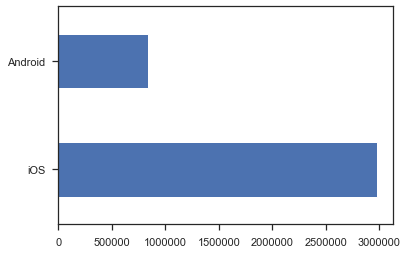

In [7]:
my_t['os_version'].value_counts().plot.barh();

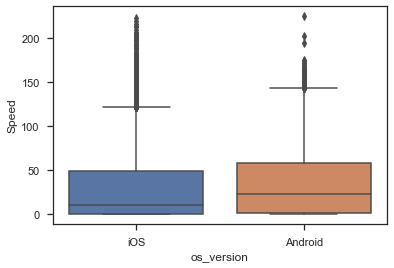

In [8]:
sns.boxplot(x="os_version", y="Speed", data=my_t)

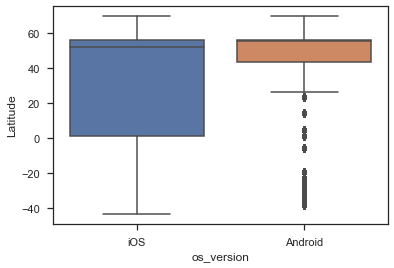

In [9]:
sns.boxplot(x="os_version", y="Latitude", data=my_t)

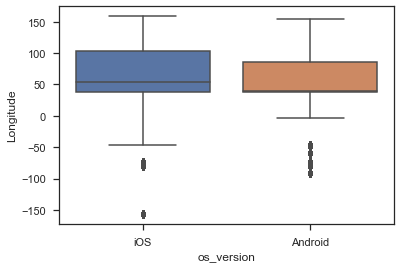

In [10]:
sns.boxplot(x="os_version", y="Longitude", data=my_t)

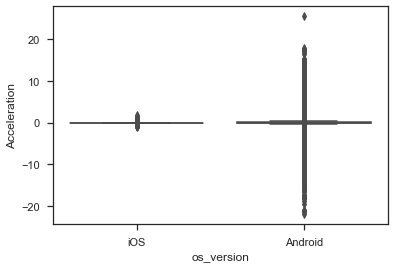

In [11]:
sns.boxplot(x="os_version", y="Acceleration", data=my_t)

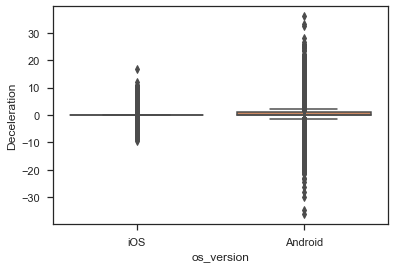

In [12]:
sns.boxplot(x="os_version", y="Deceleration", data=my_t)

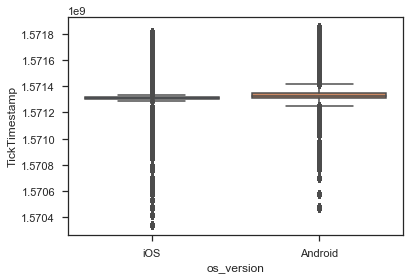

In [13]:
sns.boxplot(x="os_version", y="TickTimestamp", data=my_t)

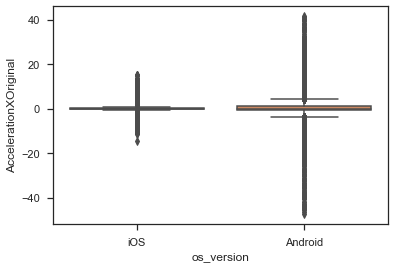

In [14]:
sns.boxplot(x="os_version", y="AccelerationXOriginal", data=my_t)

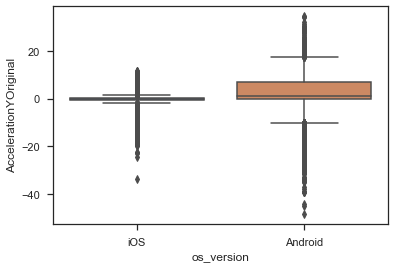

In [15]:
sns.boxplot(x="os_version", y="AccelerationYOriginal", data=my_t)

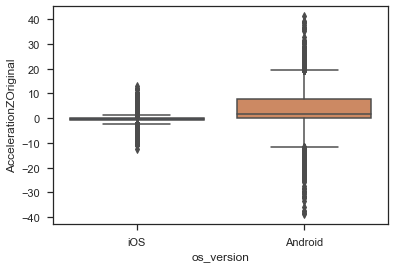

In [16]:
sns.boxplot(x="os_version", y="AccelerationZOriginal", data=my_t)

All values that represent acceleration look like they have different dimentions in different OS.

## 2. Переведите все параметры в одинаковую размерность

1. Посмотрим на коррелирующие признаки и отбросим те, которые могут помешать модели
2. Нормализуем численные признаки

In [17]:
print(cols_to_analize)

['IncomingTrackId', 'Speed', 'Latitude', 'Longitude', 'PointDate', 'Height', 'Acceleration', 'Deceleration', 'TickTimestamp', 'AccelerationXOriginal', 'AccelerationYOriginal', 'AccelerationZOriginal', 'TrackOrigin', 'ispassanger']


In [18]:
my_t = my_t[cols_to_analize]

In [52]:
pandas_profiling.ProfileReport(my_t.sample(round(my_t.shape[0]*0.01)))

KeyboardInterrupt: 

Lets drop TickTimestamp and Longitude due to correllation

In [20]:
my_t = my_t.drop(columns=['TickTimestamp', 'Longitude'])

In [21]:
my_t.shape

(3822689, 12)

In [22]:
my_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3822689 entries, 0 to 3822688
Data columns (total 12 columns):
IncomingTrackId          int64
Speed                    float64
Latitude                 float64
PointDate                object
Height                   float64
Acceleration             float64
Deceleration             float64
AccelerationXOriginal    float64
AccelerationYOriginal    float64
AccelerationZOriginal    float64
TrackOrigin              object
ispassanger              int64
dtypes: float64(8), int64(2), object(2)
memory usage: 350.0+ MB


In [23]:
my_t['ispassanger'].value_counts()

0    2899056
1     923633
Name: ispassanger, dtype: int64

All unique TrackOrigin values:

In [24]:
my_t['TrackOrigin'].unique()

array(['OriginalDriver', 'Passanger', 'Taxi'], dtype=object)

In [25]:
my_t['AccelerationZOriginal_zscore'] = (my_t.AccelerationZOriginal - my_t.AccelerationZOriginal.mean())/my_t.AccelerationZOriginal.std(ddof=0)
# my_t['AccelerationZOriginal_zscore']

In [26]:
categorical_columns = [c for c in my_t.columns if my_t[c].dtype.name == 'object']
numerical_columns   = [c for c in my_t.columns if my_t[c].dtype.name != 'object']
numerical_columns.remove('ispassanger')
print(categorical_columns)
print(numerical_columns)

['PointDate', 'TrackOrigin']
['IncomingTrackId', 'Speed', 'Latitude', 'Height', 'Acceleration', 'Deceleration', 'AccelerationXOriginal', 'AccelerationYOriginal', 'AccelerationZOriginal', 'AccelerationZOriginal_zscore']


In [27]:
for c in categorical_columns:
    print(my_t[c].unique())

['2019-10-17 15:35:23.0000000 +03:00' '2019-10-17 15:35:34.0000000 +03:00'
 '2019-10-17 15:37:28.0000000 +03:00' ...
 '2019-10-23 12:34:44.0000000 +04:00' '2019-10-23 12:34:45.0000000 +04:00'
 '2019-10-23 12:34:46.0000000 +04:00']
['OriginalDriver' 'Passanger' 'Taxi']


In [28]:
data_numerical = my_t[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
data_numerical.describe()

,IncomingTrackId,Speed,Latitude,Height,Acceleration,Deceleration,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal,AccelerationZOriginal_zscore
count,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06,3.822689e+06
mean,-1.359237e-13,-5.343200e-13,-3.101774e-13,-1.227142e-14,-2.693514e-15,2.428010e-13,-1.568428e-14,-2.918194e-14,7.152220e-14,9.298588e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.453707e+00,-8.625992e-01,-2.095684e+00,-3.686349e+00,-3.040488e+01,-3.253421e+01,-2.687885e+01,-1.781270e+01,-1.344837e+01,-1.344837e+01
25%,-1.440812e-01,-8.600586e-01,-8.554802e-01,-5.885655e-01,-8.113991e-02,-1.030642e-01,-1.795231e-01,-3.718626e-01,-4.035180e-01,-4.035180e-01
50%,-5.999127e-02,-4.613654e-01,5.744294e-01,-1.024264e-01,-8.113991e-02,-1.030642e-01,-5.537089e-02,-1.431376e-01,-2.198127e-01,-2.198127e-01
75%,9.360261e-02,7.087255e-01,6.606778e-01,2.441756e-01,-8.113991e-02,-1.030642e-01,5.569406e-02,2.589308e-02,-1.301652e-02,-1.301652e-02
max,3.495149e+00,6.060875e+00,1.043311e+00,1.896468e+01,3.521833e+01,3.228169e+01,2.343636e+01,1.251143e+01,1.410654e+01,1.410654e+01


In [29]:
my_t = pd.concat((data_numerical, my_t['ispassanger']), axis=1)
my_t = pd.DataFrame(my_t, dtype=float)
print (my_t.shape)
print (my_t.columns)

(3822689, 11)
Index(['IncomingTrackId', 'Speed', 'Latitude', 'Height', 'Acceleration',
       'Deceleration', 'AccelerationXOriginal', 'AccelerationYOriginal',
       'AccelerationZOriginal', 'AccelerationZOriginal_zscore', 'ispassanger'],
      dtype='object')


# # 3. В richtracks для каждого трека есть поле TrackOrigin, которое описывает кем была произведена поездка: владельцем смартфона или нет. 

1. Поделим данные на обучающую и тестовые выборки
2. Обучим модель логистической регрессии

In [30]:
my_cols = set(my_t.columns)
my_cols.remove('ispassanger')

In [31]:
y = my_t['ispassanger']
X = my_t[my_cols]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
feature_names = X.columns
print(feature_names)

Index(['AccelerationYOriginal', 'Speed', 'AccelerationZOriginal', 'Height',
       'AccelerationZOriginal_zscore', 'Latitude', 'AccelerationXOriginal',
       'IncomingTrackId', 'Deceleration', 'Acceleration'],
      dtype='object')


In [32]:
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

3058151 764538


In [48]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(n_jobs=-1)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred=logreg.predict(X_test)

# summarize the fit of the model
print(metrics.classification_report(y_test, y_pred))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.77      0.98      0.87    579811
         1.0       0.66      0.09      0.17    184727

    accuracy                           0.77    764538
   macro avg       0.72      0.54      0.52    764538
weighted avg       0.75      0.77      0.70    764538



Text(0.5, 257.44, 'Predicted label')

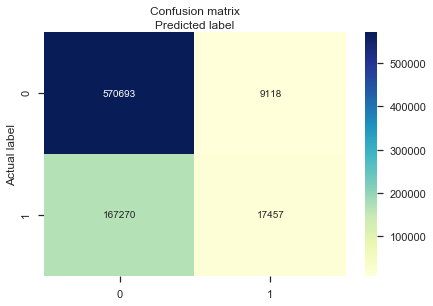

In [49]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [50]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7692881190993777
Precision: 0.65689557855127
Recall: 0.09450161589805496
